In [1]:
import os
import sys
import time
import itertools
import numpy as np

# Torch
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
print("Torch Version:", torch.__version__)

sys.path.append("../../")

# Planning
sys.path.append("../Planning/")
import Planners as Planners

# Control
sys.path.append("../Acting/")
import TrajectorySamplers as TrajectorySamplers

# Model
sys.path.append("../Learning/")
import Models as Models
from Models import weights_init

# Simple RL
from simple_rl.tasks import NavigationWorldMDP
from simple_rl.tasks.navigation.NavigationWorldMDP import NavigationWorldMDP, generate_states, NavigationWorldState

# IRL
sys.path.append("../MLIRL")
from MLIRL import MLIRL

# MaxEnt
sys.path.append("../MaxEntIRL")
from MaxEntIRL import *

# Eval
sys.path.append("../utils/")
from Evaluation import *

from helper import convert_to_grid, plot_irl_gridworld, plot_irl_results

import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable
# style.use('classic')
%matplotlib inline

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 55

%matplotlib inline
%load_ext autoreload
%autoreload 2

Torch Version: 0.5.0a0+ab6afc2


ModuleNotFoundError: No module named 'helper'

## Environment

In [ ]:
# traj = TrajectorySamplers.astar_find_path(S[0], S[10], A, T, cost_fn=lambda s: -R_s(s))

In [ ]:
# policy = lambda Q, temp=temperature: Planners.log_boltzmann_dist(Q, temp)
# Planners.value_iteration(S, A, R, T, policy, 0.95, 100, )


In [ ]:
# len([reward_living, *[reward_obtacle]*len(obstacle_cells)])

In [7]:
# len([1., *[[o] for o in obstacle_cells]])

## Navigation Grid World (noisy features)

(<Figure size 1440x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x134d22e80>)

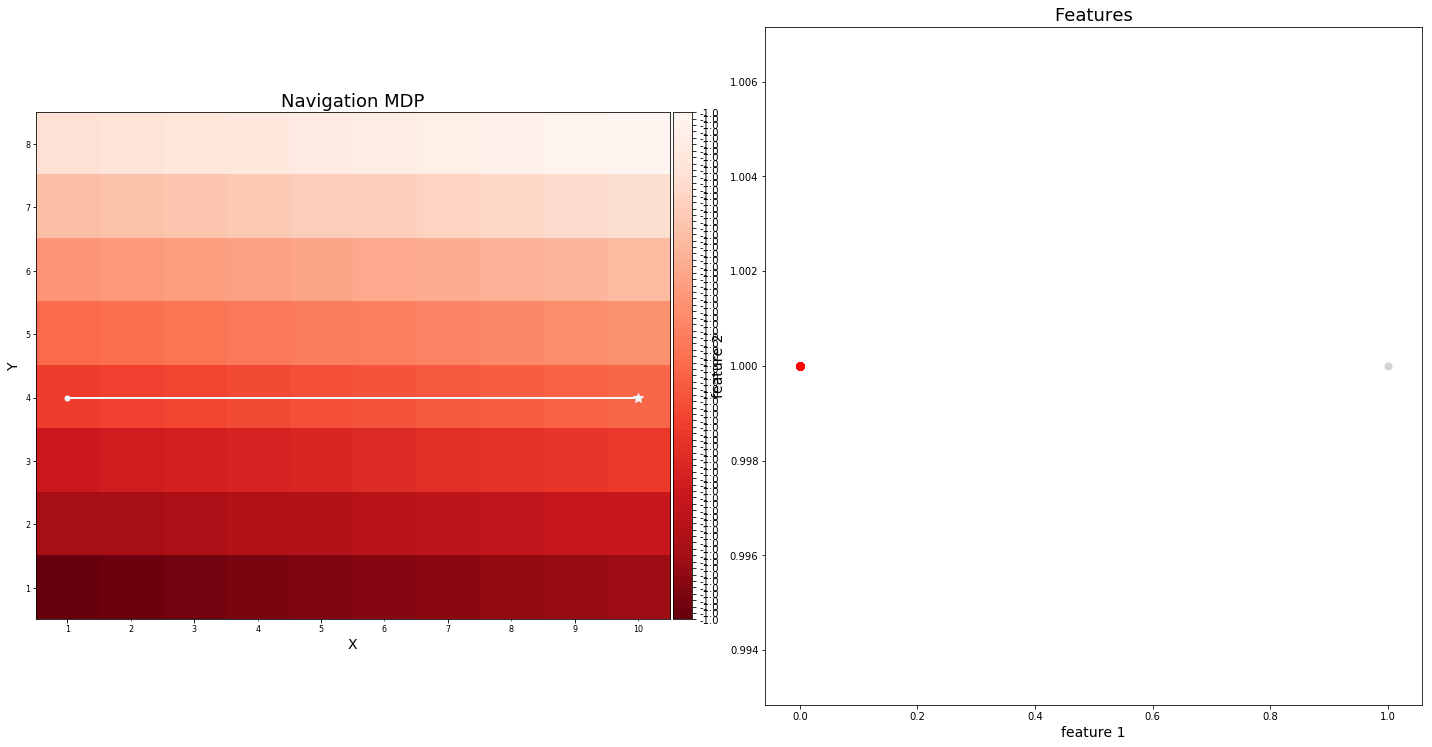

In [63]:
np.random.seed(1)
torch.manual_seed(1)

obstacle = lambda x, y, w, h: [(x+i, y+j) for j in range(h) for i in range(w)]

W, H = 10, 8
n_obstacles = 1

reward_living = -0.01
reward_obtacle = -1.0
obstacle_cells = list(itertools.chain(*[o() for o in generate_obstacles(
                              W, H, n_obstacles, 
                              obstacle_w_mu=10, obstacle_w_std=0.001, 
                              obstacle_h_mu=10, obstacle_h_std=0.001,
                              buffer_w=0, buffer_h=0, max_search_tries=100)]))
nvmdp = NavigationWorldMDP(
    
    width = W, height = H,
    nav_cell_types = [*range(len(obstacle_cells))],
    nav_cell_rewards = [*[reward_obtacle]*len(obstacle_cells)], # To create separate indicator feature for each obstacle cell.
    nav_cell_p_or_locs = [*[[o] for o in obstacle_cells]],
    goal_cell_types = [],
    goal_cell_rewards = [],
    goal_cell_locs = [],
    slip_prob = 0.0, step_cost = 0,
    gamma = 0.95
)



S = nvmdp.get_all_states()
s_to_idx = {v:k for k,v in enumerate(S)}
R_s = nvmdp._reward_func_state_only
R = torch.tensor([float(R_s(s)) for s in S], requires_grad=True)
R_grid = convert_to_grid(nvmdp, S, R)
A = nvmdp.get_actions()
a_to_idx = {a:i for i,a in enumerate(A)}
T = nvmdp.transition_func
shortest_path_fn = lambda s, g: Planners.astar_find_path(s, g, A, T, cost_fn=lambda s: -R_s(s),
                            heuristic_fn=lambda s1, s2: (-reward_living) * np.linalg.norm(np.array(s1) - np.array(s2)))

def states_generator(trajectory):
    return S

def dynamics_generator(trajectory):
    return lambda s,a: [(T(s,a), 1.)]

# assert len(astar_find_path(S[0], S[10], A, T, cost_fn=lambda s: -R_s(s))) == 13

# Features
state_ids = [nvmdp.map_state_cell_id[nvmdp._xy_to_rowcol(*s)] for s in S]
linear_phi = torch.FloatTensor([state_id_to_linear_feature(s_id) for s_id in state_ids])
non_linear_phi = torch.FloatTensor([state_id_to_non_linear_feature(s_id) for s_id in state_ids])
one_hot_phi = torch.FloatTensor([nvmdp.feature_at_state(s) for s in S])

# phi = linear_phi
phi = one_hot_phi
phi_fn = lambda s: phi[s_to_idx[s]]

# Sample demonstrations
n_traj = 1
# nvmdp.set_traj_init_cell_types(["lightgrey"])
# trajectories = TrajectorySamplers.sample_shortest_path_trajectories(
#     nvmdp.sample_init_states(n_traj), nvmdp.sample_init_states(n_traj), shortest_path_fn)
trajectories = TrajectorySamplers.sample_shortest_path_trajectories(
    [NavigationWorldState(1,4)]*n_traj, [NavigationWorldState(10,4)]*n_traj, shortest_path_fn)

trajectories_states = [list(zip(*traj))[0] for traj in trajectories]
assert not trajectories[0][-1][1]

fig = plt.figure(figsize=(20,10)) 
plot_irl_gridworld(nvmdp, phi, state_ids, fig, "12", 1)


# MaxEnt

In [64]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, mean=-1, std=0.01)

In [65]:
lr, weight_decay = 0.1, 1e-3
phi_dim = len(phi_fn(S[0]))
temperature = 1 # Not needed in MaxEnt
gamma = 0.95
n_vi_iters = 400
n_maxent_iters = 20

np.random.seed(1)
torch.manual_seed(1)
# R model
R_model = Models.LinearRewardModel_ReLU(phi_dim)
R_model.apply(weights_init)

# Test: non-positive R
assert np.alltrue(np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(100,phi_dim))]) <= 0)
# Optimizer
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

maxent_loss_history, learned_policies = MaxEntIRL(
    trajectories, states_generator, dynamics_generator, A, phi_fn, 
    R_model, R_optimizer, gamma, n_maxent_iters, n_vi_iters, boltzmann_temp=temperature,
    verbose=True, debug=False, insane_debug=False)

MaxEntIRL params 
-----
	 Domains: 1, sizes: [80],
	 Action dim: 4, 
	 Feature dim: 80,
	 Iterations: 20, 
	 Max likelihood: 0.99,
	 VI iterations: 400, 
	 VI convergence eps: 0.001,
	 Gamma (discount factor): 0.95,
Running Backward Pass  [ .. ] Backward pass converged @ 85.

>>> Iter: 0000: loss = 00.019238, likelihood = 0.0000, CPU time = 0.426272
Running Backward Pass  [ .. ] Backward pass converged @ 84.

>>> Iter: 0001: loss = 00.017259, likelihood = 0.0000, CPU time = 0.411476
Running Backward Pass  [ .. ] Backward pass converged @ 87.

>>> Iter: 0002: loss = 00.014913, likelihood = 0.0000, CPU time = 0.403639
Running Backward Pass  [ .. ] Backward pass converged @ 89.

>>> Iter: 0003: loss = 00.012613, likelihood = 0.0000, CPU time = 0.426543
Running Backward Pass  [ ... ] Backward pass converged @ 91.

>>> Iter: 0004: loss = 00.010807, likelihood = 0.0000, CPU time = 0.419098
Running Backward Pass  [ ... ] Backward pass converged @ 93.

>>> Iter: 0005: loss = 00.009341, likelih

(<Figure size 1008x1008 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13139c048>)

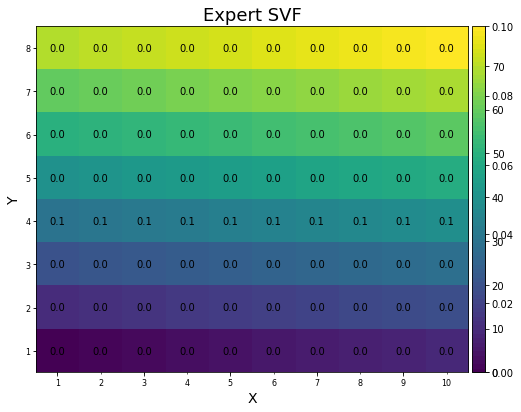

In [66]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(211)
plt.plot([R_model(phi_fn(s)) for s in S])
plt.title("Reward")
nvmdp.visualize_grid(nvmdp.convert_array_to_grid(compute_svf(trajectories, S), S), 
                     show_colorbar=True, title="Expert SVF", subplot_str="212", fig=fig, ax=ax)
nvmdp.visualize_grid(show_colorbar=True, title="Expert SVF", subplot_str="213", fig=fig, ax=ax,
                     text_values=nvmdp.convert_array_to_grid(compute_svf(trajectories, S), S).round(2))

In [67]:
data = trajectories

In [71]:
list(zip(A, learned_policies[0][s_to_idx[trajectories[0][1][0]]]))

[('up', 0.015529035),
 ('down', 0.012424933),
 ('left', 0.005991831),
 ('right', 0.96605414)]

In [80]:
trajectories[0]

[(s: (x = 1, y = 4), 'right'),
 (s: (x = 2, y = 4), 'right'),
 (s: (x = 3, y = 4), 'right'),
 (s: (x = 4, y = 4), 'right'),
 (s: (x = 5, y = 4), 'right'),
 (s: (x = 6, y = 4), 'right'),
 (s: (x = 7, y = 4), 'right'),
 (s: (x = 8, y = 4), 'right'),
 (s: (x = 9, y = 4), 'right'),
 (s: (x = 10, y = 4), None)]

In [106]:
list(zip(A, learned_policies[0][s_to_idx[trajectories[0][8][0]]]))

[('up', 0.5380959),
 ('down', 0.28712186),
 ('left', 0.17478147),
 ('right', 2.2616228e-10)]

In [111]:
traj_log_likelihood(trajectories[0][:8], s_to_idx, a_to_idx, learned_policies[0]) 

-0.7951182425022125

In [69]:
def log_likelihood_data_domains(data, states_generator_fn, dynamics_generator_fn, A, learned_policies):
    
    lik_sum = 0.
    for idx, trajectory in enumerate(data):

        S = states_generator_fn(trajectory)
        Pi = learned_policies[idx] 
        s_to_idx = {v:k for k,v in enumerate(S)}
        a_to_idx = {a:i for i,a in enumerate(A)}
        lik_sum += traj_log_likelihood(trajectory, s_to_idx, a_to_idx, torch.tensor(Pi))
    return lik_sum

In [74]:
log_likelihood_data_domains(trajectories, states_generator, dynamics_generator, A, learned_policies)

tensor(-23.4488)

In [117]:
R = torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False)
maxent_R_grid = convert_to_grid(nvmdp, S, R)
fig = plt.figure(figsize=(20,20)) 
plot_irl_gridworld(nvmdp, phi, state_ids, fig, "32", 1)
plot_irl_results(nvmdp, fig, maxent_R_grid, maxent_loss_history, False, 
                 "Deep MaxEnt (indicator features, linear rewards), Temp: {}".format(temperature), "32", 3, ylabel="normalized L1 svf diff")
plt.tight_layout()

AttributeError: 'LinearRewardModel_ReLU' object has no attribute 'out_bias'

## MLIRL

In [113]:
lr, weight_decay = 0.1, 0
phi_dim = len(phi_fn(S[0]))
temperature = 0.1
gamma = 0.95
n_vi_iters = 400
n_mlirl_iters = 20

np.random.seed(1)
torch.manual_seed(1)
# R model
R_model = Models.LinearRewardModel_ReLU(phi_dim, 0)
R_model.apply(weights_init)
# for p in R_model.parameters():
#     print(p)
# Test: non-positive R
# assert np.alltrue(np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(100,phi_dim))]) <= 0)
# Optimizer
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

policy = lambda Q, temp=temperature: Planners.log_boltzmann_dist(Q, temp)

maxent_loss_history3 = MLIRL(
                trajectories, states_generator, dynamics_generator, A, phi_fn, R_model, R_optimizer, 
                policy, gamma, n_mlirl_iters, n_vi_iters)

R3 = torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False)
maxent_R3_grid = convert_to_grid(nvmdp, S, R3)
R3_model = R_model

MLIRL params 
-----
	 Domains: 1, sizes: [80],
	 Action dim: 4, 
	 Feature dim: 80,
	 Iterations: 20, 
	 Max likelihood: 0.99,
	 VI iterations: 400, 
	 VI convergence eps: 0.001,
	 Policy example: Q 0.95 -> Pi tensor([0.0000, 0.3333, 0.6667, 1.0000])

>>> Iter: 0000: loss = 00.001583, likelihood = 0.9984, CPU time = 0.784934

>>> Iter: 0000 Converged.




ValueError: only one element tensors can be converted to Python scalars

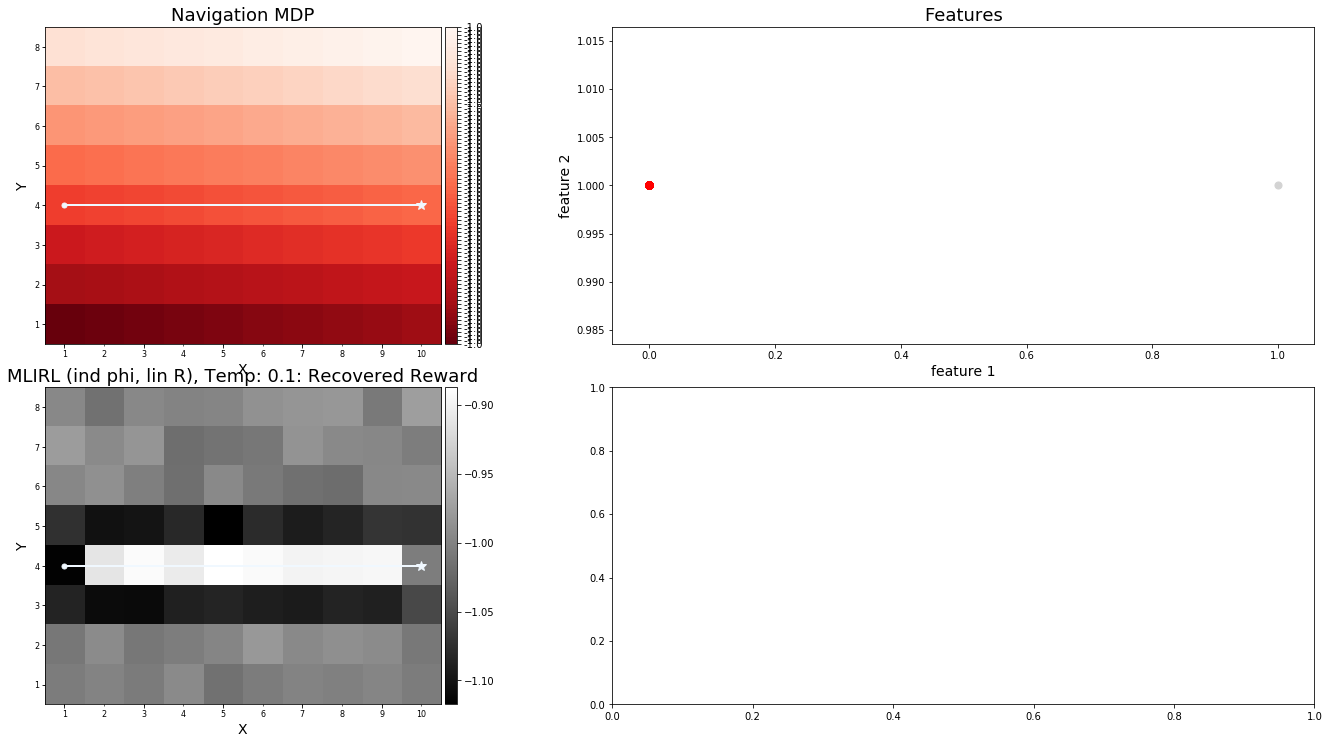

In [114]:
fig = plt.figure(figsize=(20,20))
plot_irl_gridworld(nvmdp, phi, state_ids, fig, "42", 1)
plot_irl_results(nvmdp, fig, maxent_R3_grid, maxent_loss_history3, True, 
                 "MLIRL (ind phi, lin R), Temp: {}".format(0.1), 
                 "42", 3, ylabel="Likelihood")
plot_irl_results(nvmdp, fig, maxent_R4_grid, maxent_loss_history4, True, 
                 "MLIRL (ind phi, lin R), Temp: {}".format(1.0), 
                 "42", 5, ylabel="Likelihood")
plot_irl_results(nvmdp, fig, maxent_R5_grid, maxent_loss_history5, True, 
                 "MLIRL (ind phi, lin R), Temp: {}".format(10.0), 
                 "42", 7, ylabel="Likelihood")
plt.tight_layout()

In [491]:
lr, weight_decay = 0.01, 1e-5
phi_dim = len(phi_fn(S[0]))
gamma = 0.95
n_vi_iters = 50
n_mlirl_iters = 100
temperature = 0.1

np.random.seed(1)
torch.manual_seed(1)
R_model_tanh = Models.LinearRewardModel_Tanh(phi_dim, -1)
np.random.seed(1)
torch.manual_seed(1)
R_model_relu = Models.LinearRewardModel_ReLU(phi_dim, -1)

Text(0.5,1,'Reward initialization')

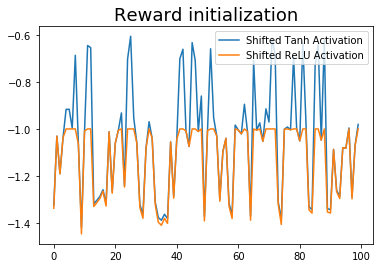

In [23]:
plt.plot([R_model_tanh(phi_fn(s)).item() for s in S], label="Shifted Tanh Activation")
plt.plot([R_model_relu(phi_fn(s)).item() for s in S], label="Shifted ReLU Activation")
plt.legend()
plt.title("Reward initialization")

In [24]:
(0.1**4)**(1/4)

0.1

In [25]:
(0.1 * 0.2 * 0.5 * 0.9)**(1/4)

0.3080070288241023

In [26]:
np.exp((1./8)*np.log(.1)*8)

0.10000000000000002

## Reward with Tanh Activation

In [27]:
# R model
R_model = R_model_tanh
# Test: non-positive R
# assert np.alltrue(np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(100,phi_dim))]) <= 0)
# Optimizer
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)
policy = lambda Q, temp=temperature: Planners.log_boltzmann_dist(Q, temp)
# MLIRL
loss_history_tanh = MLIRL(
    trajectories, states_generator, dynamics_generator, A, phi_fn, R_model, R_optimizer, 
    policy, gamma, n_mlirl_iters, n_vi_iters)


MLIRL params 
-----
	 Domains: 4, sizes: [100, 100, 100, 100],
	 Action dim: 4, 
	 Feature dim: 2,
	 Iterations: 100, 
	 Max likelihood: 0.99,
	 VI iterations: 50, 
	 VI convergence eps: 0.001,
	 Gamma (discount factor): 0.95,
	 Policy example: Q tensor([0.0000, 0.3333, 0.6667, 1.0000]) -> Pi tensor([-10.0363,  -6.7030,  -3.3697,  -0.0363])
.........
>>> Iter: 0000: loss = 02.249325, likelihood = 0.1055, CPU time = 5.460515
.........
>>> Iter: 0001: loss = 02.191391, likelihood = 0.1118, CPU time = 5.312689
........
>>> Iter: 0002: loss = 02.133292, likelihood = 0.1184, CPU time = 5.184992
........
>>> Iter: 0003: loss = 02.075011, likelihood = 0.1256, CPU time = 5.141945
........
>>> Iter: 0004: loss = 02.016523, likelihood = 0.1331, CPU time = 5.134649
........
>>> Iter: 0005: loss = 01.957809, likelihood = 0.1412, CPU time = 5.525856
........
>>> Iter: 0006: loss = 01.898872, likelihood = 0.1497, CPU time = 5.396238
........
>>> Iter: 0007: loss = 01.839680, likelihood = 0.1589, CPU

........
>>> Iter: 0094: loss = 00.156721, likelihood = 0.8549, CPU time = 5.590282
........
>>> Iter: 0095: loss = 00.155965, likelihood = 0.8556, CPU time = 5.658231
........
>>> Iter: 0096: loss = 00.155205, likelihood = 0.8562, CPU time = 5.622727
........
>>> Iter: 0097: loss = 00.154488, likelihood = 0.8569, CPU time = 5.643716
........
>>> Iter: 0098: loss = 00.153774, likelihood = 0.8575, CPU time = 5.685884
........
>>> Iter: 0099: loss = 00.153069, likelihood = 0.8581, CPU time = 6.016330


## Reward with RELU Activation

In [29]:
# R model
R_model = R_model_relu
# Test: non-positive R
assert np.alltrue(np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(100,phi_dim))]) <= 0)
# Optimizer
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)
# MLIRL
loss_history_relu = MLIRL(
    trajectories, states_generator, dynamics_generator, A, phi_fn, R_model, R_optimizer, 
    policy, gamma, n_mlirl_iters, n_vi_iters)


MLIRL params 
-----
	 Domains: 4, sizes: [100, 100, 100, 100],
	 Action dim: 4, 
	 Feature dim: 2,
	 Iterations: 100, 
	 Max likelihood: 0.99,
	 VI iterations: 50, 
	 VI convergence eps: 0.001,
	 Gamma (discount factor): 0.95,
	 Policy example: Q tensor([0.0000, 0.3333, 0.6667, 1.0000]) -> Pi tensor([-10.0363,  -6.7030,  -3.3697,  -0.0363])
.........
>>> Iter: 0000: loss = 01.126681, likelihood = 0.3241, CPU time = 5.359791
.........
>>> Iter: 0001: loss = 01.100973, likelihood = 0.3325, CPU time = 5.308675
.........
>>> Iter: 0002: loss = 01.075247, likelihood = 0.3412, CPU time = 5.514773
.........
>>> Iter: 0003: loss = 01.049652, likelihood = 0.3501, CPU time = 5.788839
.........
>>> Iter: 0004: loss = 01.024096, likelihood = 0.3591, CPU time = 5.761304
.........
>>> Iter: 0005: loss = 00.998646, likelihood = 0.3684, CPU time = 5.701409
.........
>>> Iter: 0006: loss = 00.973209, likelihood = 0.3779, CPU time = 5.878197
.........
>>> Iter: 0007: loss = 00.947847, likelihood = 0.387

........
>>> Iter: 0094: loss = 00.216336, likelihood = 0.8055, CPU time = 9.193370
........
>>> Iter: 0095: loss = 00.214983, likelihood = 0.8066, CPU time = 5.554636
........
>>> Iter: 0096: loss = 00.213788, likelihood = 0.8075, CPU time = 9.207065
........
>>> Iter: 0097: loss = 00.212569, likelihood = 0.8085, CPU time = 7.724628
........
>>> Iter: 0098: loss = 00.211415, likelihood = 0.8094, CPU time = 7.284097
........
>>> Iter: 0099: loss = 00.210321, likelihood = 0.8103, CPU time = 18.952607


(-2, 0)

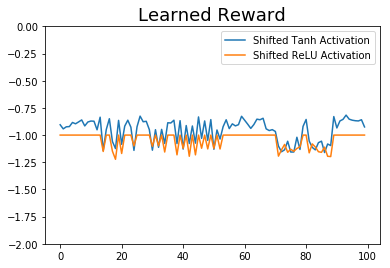

In [30]:
R_grid_tanh = convert_to_grid(nvmdp, S, [R_model_tanh(phi_fn(s)).item() for s in S])
R_grid_relu = convert_to_grid(nvmdp, S, [R_model_relu(phi_fn(s)).item() for s in S])

plt.plot(R_grid_tanh.flatten(), label="Shifted Tanh Activation")
plt.plot(R_grid_relu.flatten(), label="Shifted ReLU Activation")
plt.legend()
plt.title("Learned Reward")
plt.ylim([-2, 0])

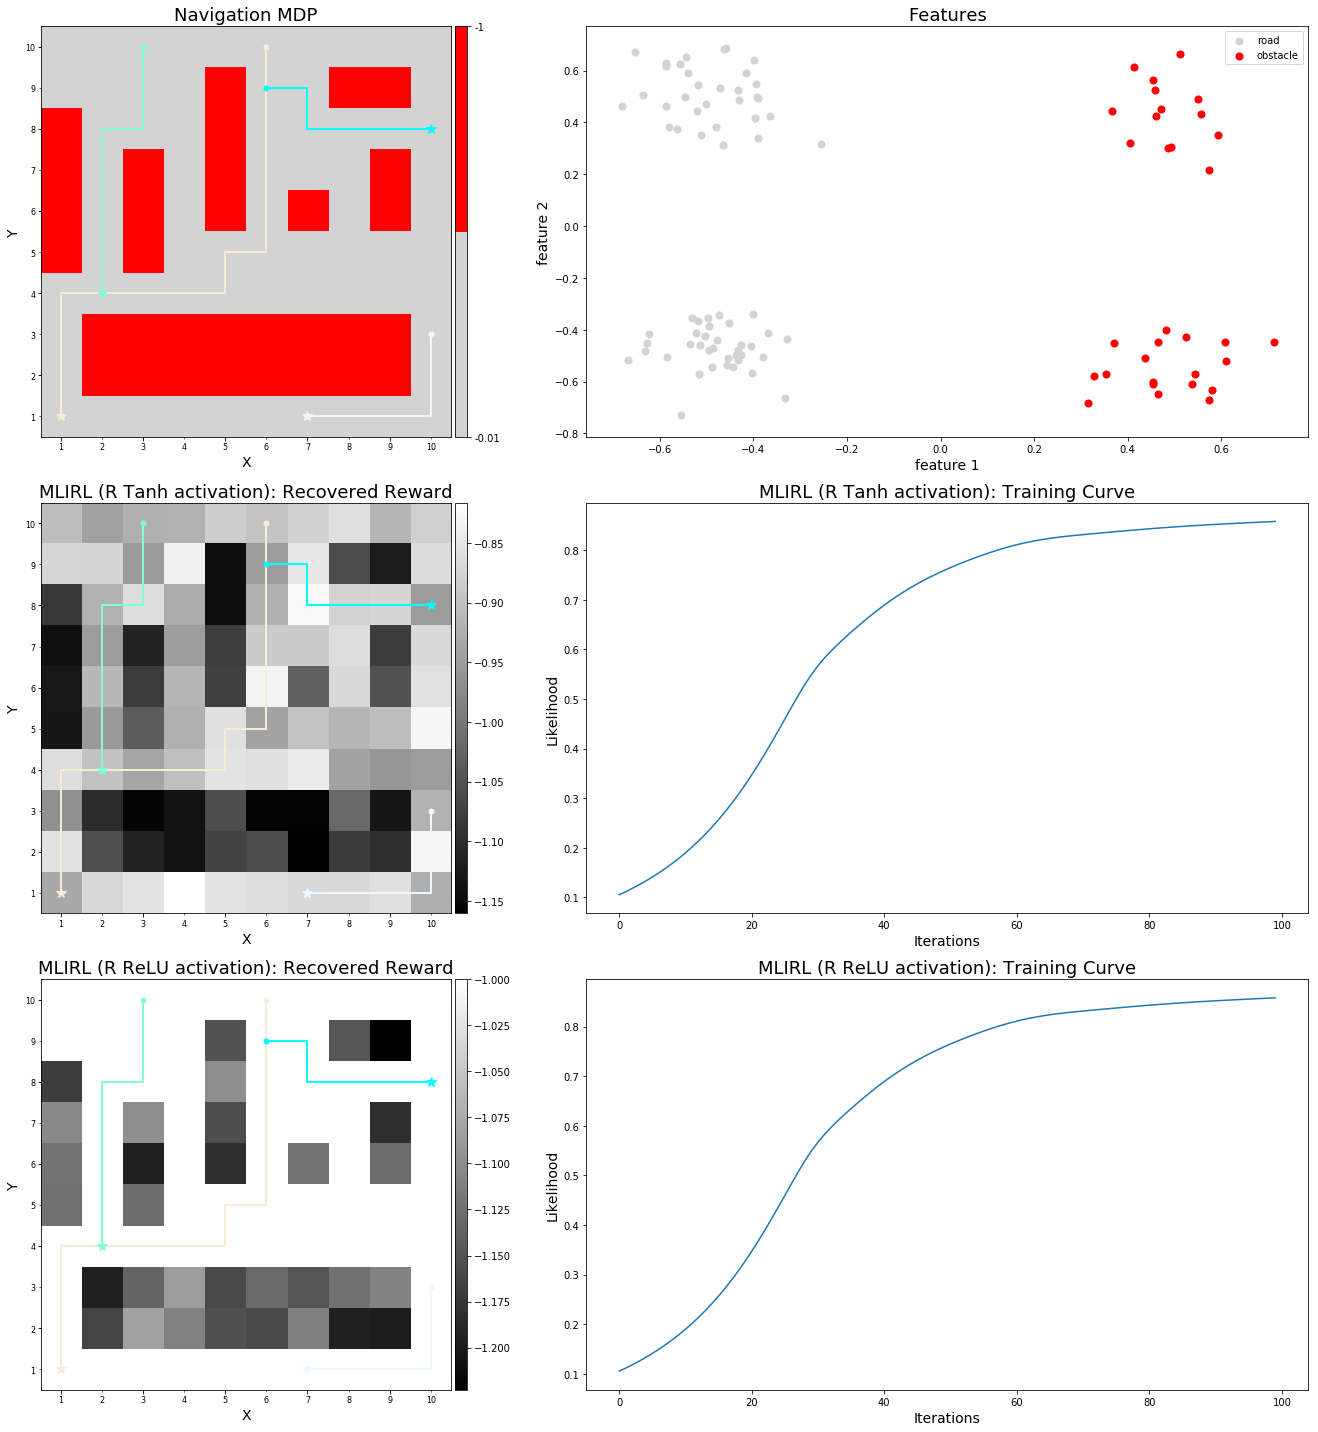

In [41]:
fig = plt.figure(figsize=(20,20)) 
plot_irl_gridworld(nvmdp, phi, fig, "32", 1)
plot_irl_results(nvmdp, R_grid_tanh, loss_history_tanh, fig, "MLIRL (R Tanh activation)", "32", 3)
plot_irl_results(nvmdp, R_grid_relu, loss_history_tanh, fig, "MLIRL (R ReLU activation)", "32", 5)
plt.tight_layout()